Dataset Info.
train.csv [파일]
ID : 샘플별 고유 ID
label : 아이콘의 종류(airplane, apple, ball, bird, building, cat, emotion_face, police_car, rabbit, truck)
0 ~ 1023 : 각 이미지의 픽셀 값(Grayscale, 32×32 해상도)을 1D 배열로 펼쳐 저장한 형태


test.csv [파일]
ID : 샘플별 고유 ID
0 ~ 1023 : 각 이미지의 픽셀 값(Grayscale, 32×32 해상도)을 1D 배열로 펼쳐 저장한 형태


sample_submission.csv [파일] - 제출 양식
ID : 샘플별 고유 ID
label : 예측한 아이콘 종류


In [90]:
#필요한 라이브러리 호출
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [34]:
#test.csv 파일을 불러온다.
test_path = './open/test.csv'
test_data = pd.read_csv(test_path)
train_path = './open/train.csv'
train_data = pd.read_csv(train_path)


In [35]:
# test.csv 파일 최소값 최대값 확인
print(pd.DataFrame(test_data.describe().loc[['min','max']]))
# 최대값 확인 시 0~255 사이의 값이므로 이미지 데이터로 추정할 수 있다.



         0      1      2      3      4      5      6      7      8      9  \
min    0.0    0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0   
max  255.0  255.0  255.0  254.0  255.0  255.0  255.0  255.0  255.0  253.0   

     ...   1014   1015   1016   1017   1018   1019   1020   1021   1022   1023  
min  ...    1.0    0.0    0.0    1.0    0.0    0.0    2.0    1.0    0.0    3.0  
max  ...  254.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  255.0  

[2 rows x 1024 columns]


In [37]:
#train.csv 파일의 상위 5개 데이터 확인
print(train_data.head())


          ID     label    0    1    2    3    4    5    6    7  ...  1014  \
0  TRAIN_000  building  251  196   51   63   68   78  189   34  ...    85   
1  TRAIN_001  building  247  184  203  237  255  255  193  255  ...   242   
2  TRAIN_002  building  217  223  232  231  239  212  109  115  ...    96   
3  TRAIN_003       cat  133  149  153  138   68  157  159  166  ...   245   
4  TRAIN_004  building  240  213  187  159  112  134  239  233  ...   148   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0   195    63    30    73    65    63   201   251   248  
1   239   241   242   242   241   241   241   240   238  
2    90   103   166   191   163   190   190   206   231  
3   241   247   255   250   190   186   244   254   201  
4    59   163   133    92   196   221   194   182   251  

[5 rows x 1026 columns]


In [38]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Columns: 1026 entries, ID to 1023
dtypes: int64(1024), object(2)
memory usage: 6.0+ MB
None


In [39]:
print(train_data.describe())

#결측값 확인
print(train_data.isnull().sum())


                0           1           2           3           4           5  \
count  769.000000  769.000000  769.000000  769.000000  769.000000  769.000000   
mean   204.763329  200.617685  198.704811  197.136541  194.245774  193.608583   
std     57.652616   60.229288   62.543943   62.669402   64.572579   63.898491   
min      2.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%    193.000000  178.000000  175.000000  168.000000  165.000000  164.000000   
50%    228.000000  228.000000  228.000000  227.000000  223.000000  221.000000   
75%    245.000000  245.000000  245.000000  243.000000  242.000000  242.000000   
max    255.000000  255.000000  255.000000  255.000000  255.000000  255.000000   

                6           7           8           9  ...        1014  \
count  769.000000  769.000000  769.000000  769.000000  ...  769.000000   
mean   188.739922  185.530559  184.161248  182.566970  ...  156.827048   
std     66.509515   70.378344   70.131703   71.2

          ID     label    0    1    2    3    4    5    6    7  ...  1014  \
0  TRAIN_000  building  251  196   51   63   68   78  189   34  ...    85   
1  TRAIN_001  building  247  184  203  237  255  255  193  255  ...   242   
2  TRAIN_002  building  217  223  232  231  239  212  109  115  ...    96   
3  TRAIN_003       cat  133  149  153  138   68  157  159  166  ...   245   
4  TRAIN_004  building  240  213  187  159  112  134  239  233  ...   148   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0   195    63    30    73    65    63   201   251   248  
1   239   241   242   242   241   241   241   240   238  
2    90   103   166   191   163   190   190   206   231  
3   241   247   255   250   190   186   244   254   201  
4    59   163   133    92   196   221   194   182   251  

[5 rows x 1026 columns]
-----------------------------
     0    1    2    3    4    5    6    7    8    9  ...  1014  1015  1016  \
0  251  196   51   63   68   78  189   34   62   61  ...

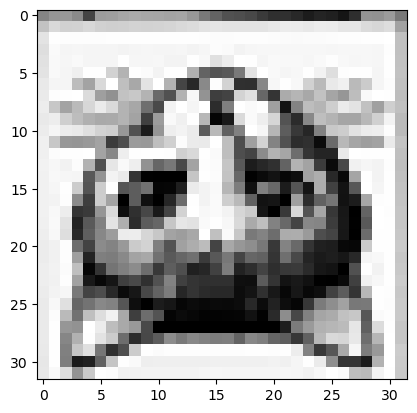

In [43]:
#test.csv 의 데이터를 활용하여 이미지 생성 하기 전에 데이터의 형태를 확인한다.
#1차원 데이터를 2차원 데이터로 변환하여 이미지를 생성한다.
#train_data의 상위 5개 데이터 확인
print(train_data.head())
print('-----------------------------')

#ID와 label을 제외한 데이터를 추출한다.
#2차원 데이터로 변환 (첫번째 두번째 열 제외)
train_data_img = train_data.iloc[:,2:]
print(train_data_img.head())

#첫번째 데이터를 2차원 이미지로 변환하여 이미지를 확인한다.
#2차원 이미지로 변환
img = train_data_img.iloc[3].values.reshape(32, 32)

#이미지 확인
plt.imshow(img, cmap='gray')

In [45]:
#전체 데이터의 라벨 확인 
print(train_data['label'].value_counts())

label
rabbit          128
bird            119
building        108
airplane         95
cat              90
emotion_face     88
apple            51
ball             37
truck            32
police_car       21
Name: count, dtype: int64


In [ ]:
#train_data의 데이터를 활용해 ML학습
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

#학습 데이터와 레이블 데이터를 분리한다.
X = train_data_img
y = train_data['label']


#train_test_split을 활용하여 학습 데이터와 테스트 데이터를 분리한다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [78]:
#학습 모델 구축하기
#RandomForest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print('RandomForest Accuracy : ', rf_accuracy)

RandomForest Accuracy :  0.8701298701298701


In [72]:
#학습 모델 구축하기
#SVM
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print('SVM Accuracy : ', svm_accuracy)

SVM Accuracy :  0.8441558441558441


In [58]:
#학습 모델 구축하기
#LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print('LogisticRegression Accuracy : ', lr_accuracy)

LogisticRegression Accuracy :  0.7857142857142857


In [59]:
#학습 모델 구축하기
#DecisionTree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print('DecisionTree Accuracy : ', dt_accuracy)


DecisionTree Accuracy :  0.5909090909090909


In [86]:
df = GradientBoostingClassifier()
df.fit(X_train, y_train)
df_pred = df.predict(X_test)
df_accuracy = accuracy_score(y_test, df_pred)
print('DecisionTree Accuracy : ', df_accuracy)

DecisionTree Accuracy :  0.7792207792207793


In [79]:
#test.csv 파일 가장 좋은 모델로 예측하기

best_model = RandomForestClassifier()#RandomForest 모델이 가장 높은 정확도를 보임
best_model.fit(X, y)

y_pred = best_model.predict(test_data.iloc[:,1:])
#
submission = pd.DataFrame({'ID': test_data['ID'], 'label': y_pred})
submission.to_csv('submission.csv', index=False)

In [80]:
#test.csv 파일 SVM모델로 예측하기

best_model = SVC()# svm모델사용 해서 확인 해보기기
best_model.fit(X, y)

y_pred = best_model.predict(test_data.iloc[:,1:])
#
submission = pd.DataFrame({'ID': test_data['ID'], 'label': y_pred})
submission.to_csv('svm.csv', index=False)

In [85]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X, y)

y_pred = best_model.predict(test_data.iloc[:,1:])
#
submission = pd.DataFrame({'ID': test_data['ID'], 'label': y_pred})
submission.to_csv('gradient_boosting.csv', index=False)

          ID     label    0    1    2    3    4    5    6    7  ...  1014  \
0  TRAIN_000  building  251  196   51   63   68   78  189   34  ...    85   
1  TRAIN_001  building  247  184  203  237  255  255  193  255  ...   242   
2  TRAIN_002  building  217  223  232  231  239  212  109  115  ...    96   
3  TRAIN_003       cat  133  149  153  138   68  157  159  166  ...   245   
4  TRAIN_004  building  240  213  187  159  112  134  239  233  ...   148   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0   195    63    30    73    65    63   201   251   248  
1   239   241   242   242   241   241   241   240   238  
2    90   103   166   191   163   190   190   206   231  
3   241   247   255   250   190   186   244   254   201  
4    59   163   133    92   196   221   194   182   251  

[5 rows x 1026 columns]
-----------------------------


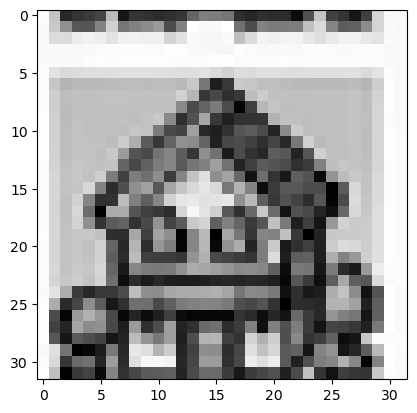

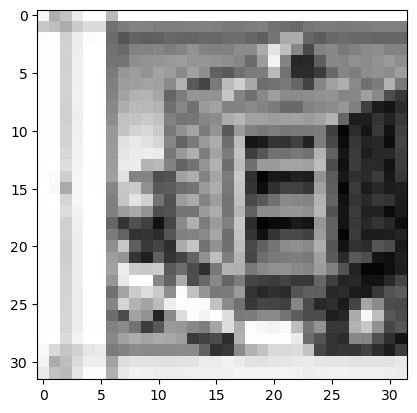

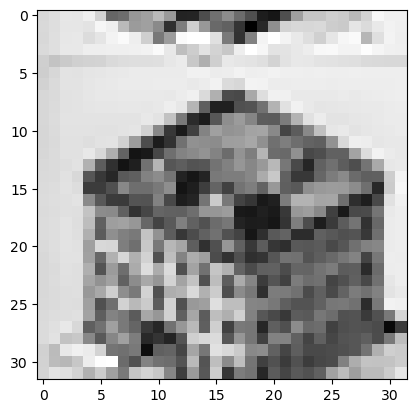

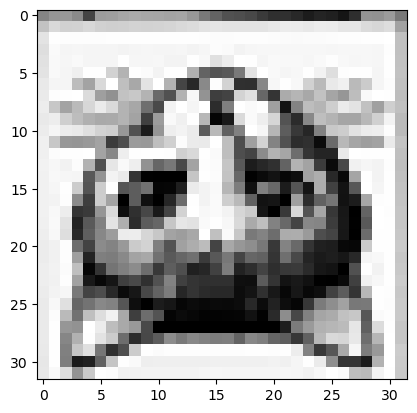

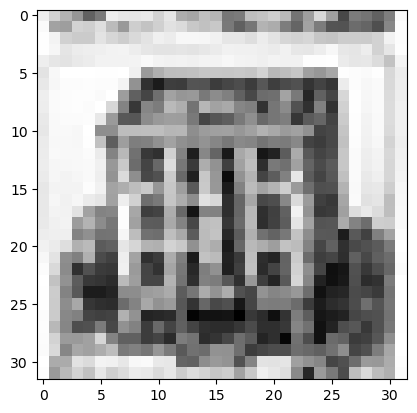

In [87]:
#이미지 픽셀 값 조절 후 다시 예측해보기기

#train_data의 상위 5개 데이터 확인하고 이미지로 변환하기
print(train_data.head())
print('-----------------------------')

for i in range(5):
    img = train_data_img.iloc[i].values.reshape(32, 32)
    plt.imshow(img, cmap='gray')
    plt.show()

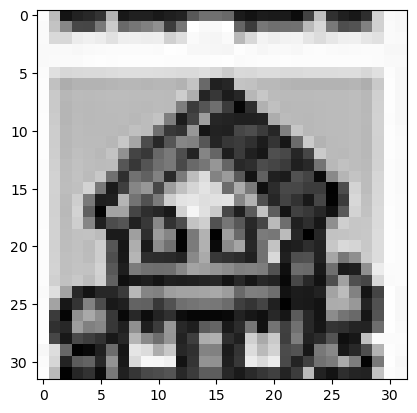

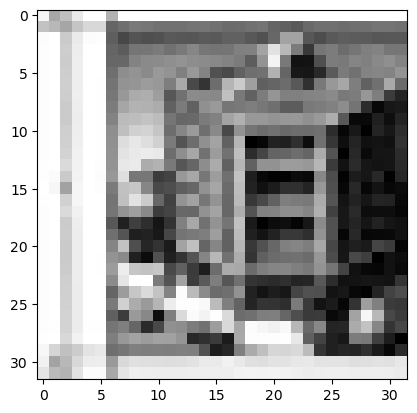

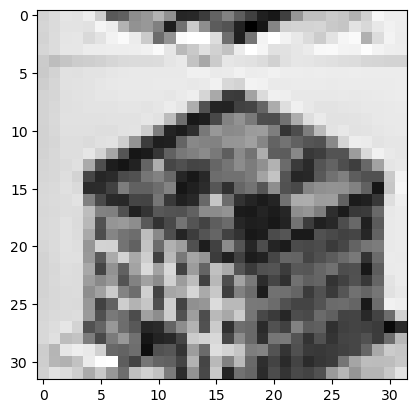

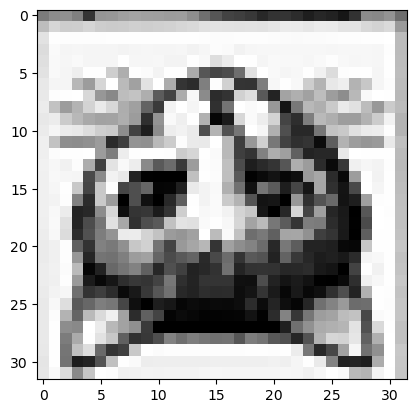

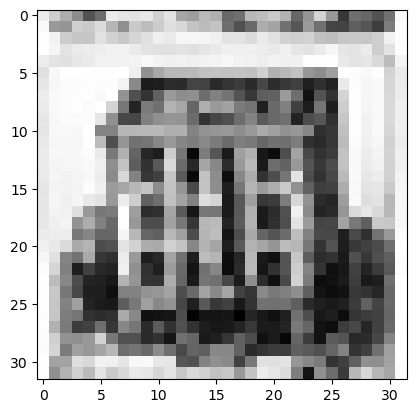

In [ ]:
# 50보다 작은 값은 +20 효과 있는지 사진으로 확인
for i in range(5):
    img = train_data_img.iloc[i].values.reshape(32, 32)
    img[img < 50] += 20
    plt.imshow(img, cmap='gray')
    plt.show()

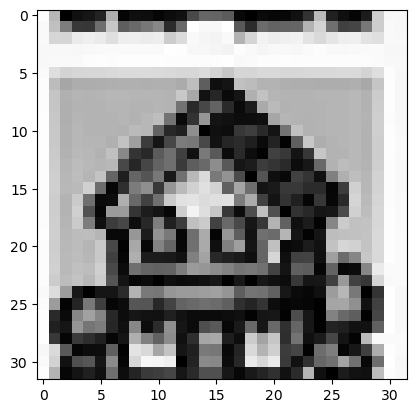

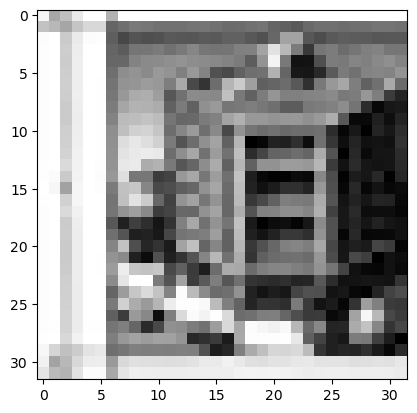

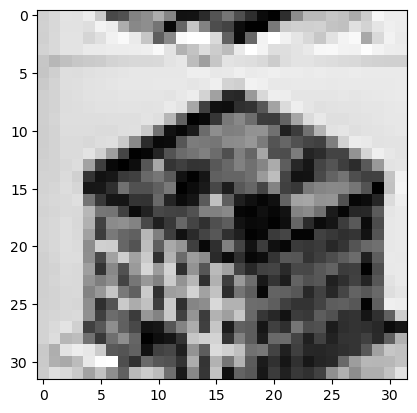

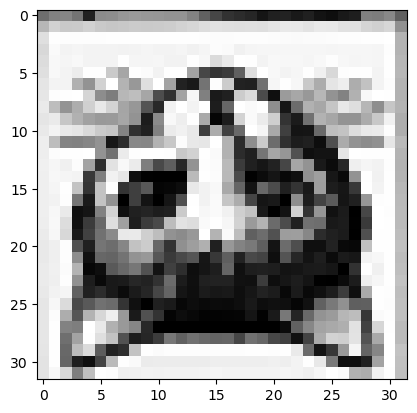

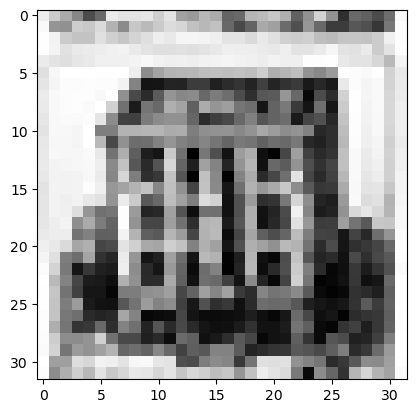

In [91]:
#흰색 부분은 값일 추가 할 필요 없음 
for i in range(5):
    img = train_data_img.iloc[i].values.reshape(32, 32)
    img_bright = np.where(img == 0, img, np.where(img < 50, img + 20, img))
    plt.imshow(img_bright, cmap='gray')
    plt.show()

In [ ]:
#흰색 부분은 값일 추가 할 필요 없음 
for i in range(): #전체 데이터 확인
    img = train_data_img.iloc[i].values.reshape(32, 32)
    img_bright = np.where(img == 0, img, np.where(img < 50, img + 30, img))
    plt.imshow(img_bright, cmap='gray')
    plt.show()

TypeError: 'DataFrame' object cannot be interpreted as an integer

In [ ]:
# train_data 전체 전처리 진행
